In [5]:
%load_ext zipline
%load_ext watermark
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

The zipline extension is already loaded. To reload it, use:
  %reload_ext zipline
The watermark extension is already loaded. To reload it, use:
  %reload_ext watermark


In [6]:
import pandas as pd
import numpy as np
from collections import OrderedDict
import pytz

# необходимые функции zipline
from zipline.api import (order, record, symbol, set_benchmark, order_target_percent, get_open_orders, order_target, 
                        schedule_function, date_rules, time_rules, order_percent, symbols)

# комиссии
from zipline.finance import commission

# выбор календаря по которому происходит торговля
from trading_calendars.always_open import AlwaysOpenCalendar

import zipline

# графика
import matplotlib.pyplot as plt
from matplotlib import style
import matplotlib.dates as mdates
import matplotlib.ticker as ticker

# работа с временем
from datetime import datetime, date

# aинансовые данные
from yahoofinancials import YahooFinancials

# ignore warnings
import warnings

# отчёт
import pyfolio as pf

# import helper functions 
import qf_helper_functions as qf

import pypfopt
from pypfopt.efficient_frontier import EfficientFrontier
from pypfopt import risk_models
from pypfopt import expected_returns

import pylab

from tqdm import tqdm

In [7]:
plt.style.use('default')
plt.rcParams['figure.figsize'] = [16, 4]
plt.rcParams['figure.dpi'] = 200
warnings.simplefilter(action='ignore', category=FutureWarning)

In [8]:
def download_csv_data(ticker, start_date, end_date, freq, path):
    
    yahoo_financials = YahooFinancials(ticker)

    df = yahoo_financials.get_historical_price_data(start_date, end_date, freq)
    df = pd.DataFrame(df[ticker]['prices']).drop(['date'], axis=1) \
            .rename(columns={'formatted_date':'date'}) \
            .loc[:, ['date','open','high','low','close', 'adjclose', 'volume']] \
            .set_index('date')
    df.index = pd.to_datetime(df.index)
    df['dividend'] = 0
    df['split'] = 1

    # save data to csv for later ingestion
    df.to_csv(path, header=True, index=True)

    # plot the time series
    df.close.plot(title='{} prices --- {}:{}'.format(ticker, start_date, end_date), color='green');

# Data

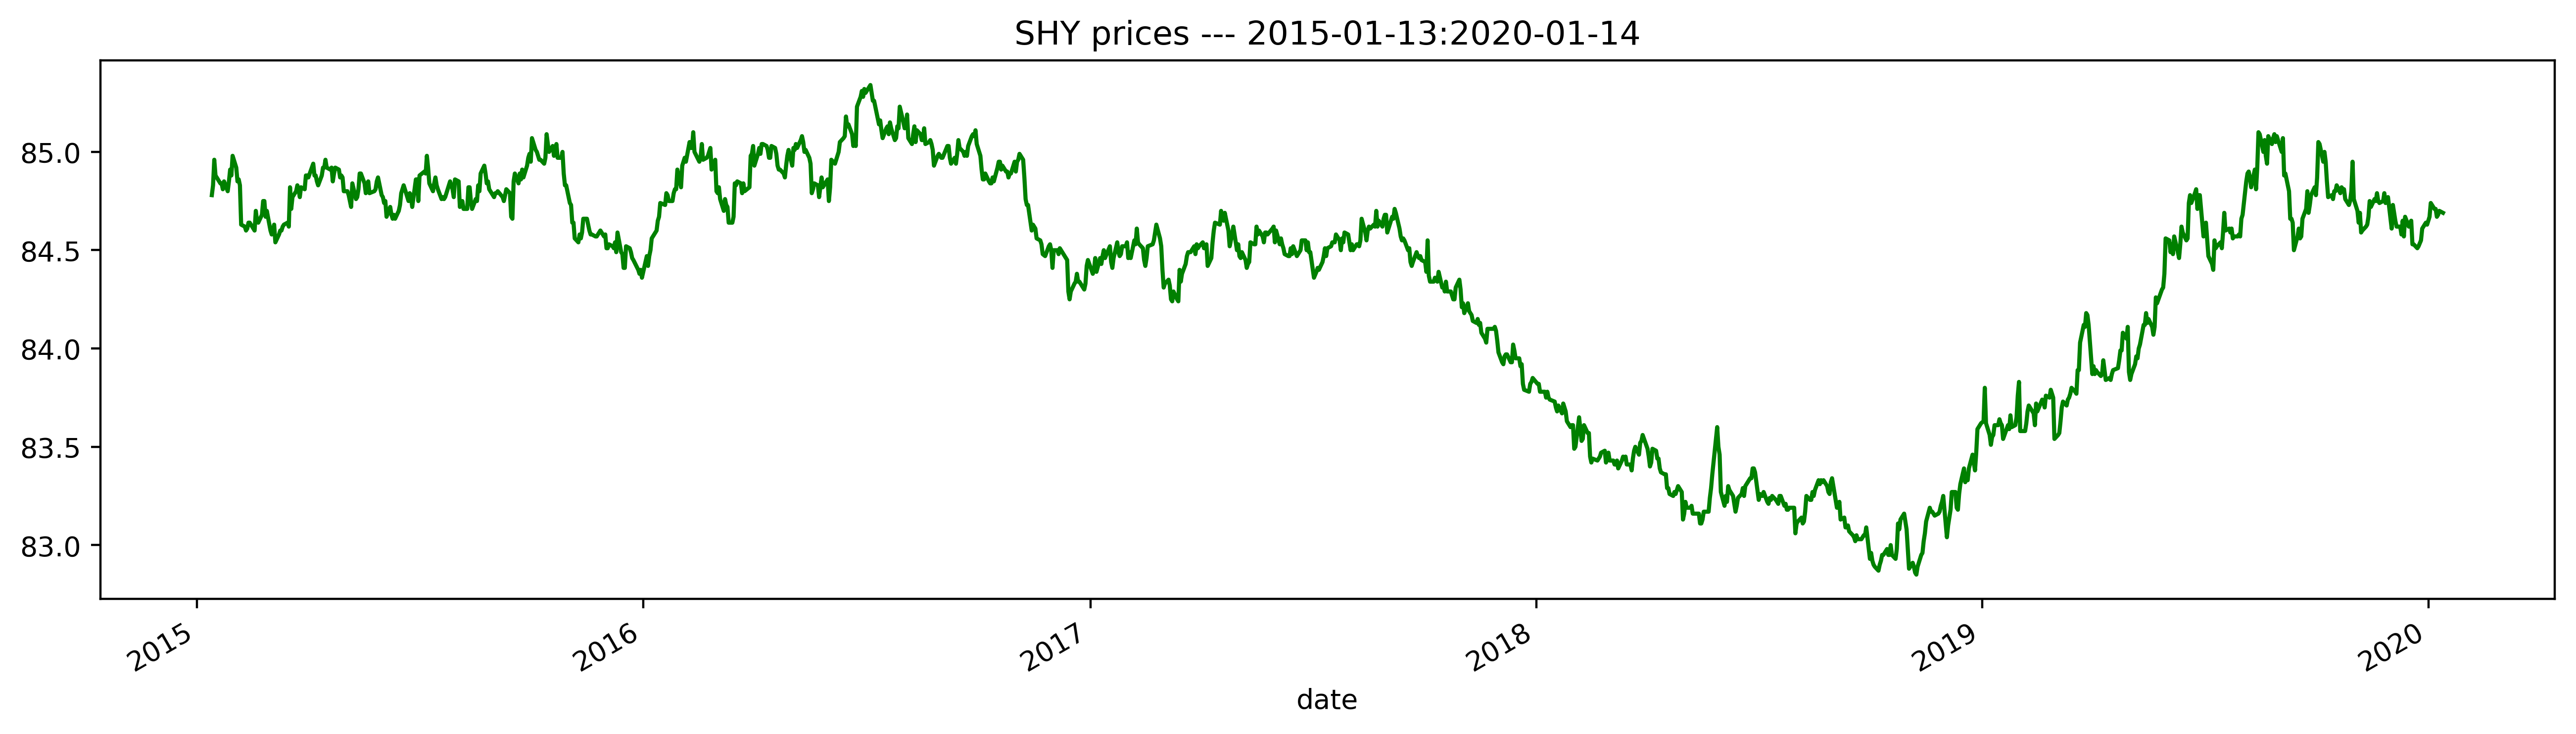

In [369]:
download_csv_data(ticker='SHY', 
                  start_date='2015-01-13', 
                  end_date='2020-01-14', 
                  freq='daily', 
                  path='data/SHY.csv')

# Симуляция

In [370]:
# Список финансовых инструментов в портфеле
TIKERS = ['SHY']

# Данные которые будут использоваться в дальнейшем
COLUMNS = ['open', 'close', 'adjclose']

In [371]:
data = OrderedDict()

for tiker in TIKERS:
    data[tiker] = pd.read_csv("data/{}.csv".format(tiker), index_col=0, parse_dates=['date'])
    data[tiker] = data[tiker][COLUMNS]
    data[tiker] = data[tiker].resample("1d").mean()
    data[tiker].fillna(method="ffill", inplace=True)
    print(data[tiker].head())

                 open      close   adjclose
date                                       
2015-01-13  84.739998  84.779999  79.782921
2015-01-14  84.849998  84.830002  79.829926
2015-01-15  84.849998  84.959999  79.952286
2015-01-16  84.930000  84.879997  79.877022
2015-01-17  84.930000  84.879997  79.877022


In [372]:
for tiker in TIKERS:
    data[tiker]['close'] = data[tiker]['adjclose']
    data[tiker]['open'] = data[tiker]['adjclose']
    del data[tiker]['adjclose']
    print(data[tiker].tail())
COLUMNS = ['open', 'close']

                 open      close
date                            
2020-01-09  84.680000  84.680000
2020-01-10  84.699997  84.699997
2020-01-11  84.699997  84.699997
2020-01-12  84.699997  84.699997
2020-01-13  84.690002  84.690002


In [373]:
panel = pd.Panel(data)
panel.minor_axis = COLUMNS
panel.major_axis = panel.major_axis.tz_localize(pytz.utc)
print(panel)

<class 'pandas.core.panel.Panel'>
Dimensions: 1 (items) x 1827 (major_axis) x 2 (minor_axis)
Items axis: SHY to SHY
Major_axis axis: 2015-01-13 00:00:00+00:00 to 2020-01-13 00:00:00+00:00
Minor_axis axis: open to close


In [374]:
WEIGHTS = [1]
COMMISSION = 0

In [375]:
def initialize(context):
    
    context.set_commission(commission.PerDollar(cost=COMMISSION))
    
    #set_benchmark(symbol('VPGDX'))
    
    context.tikers = TIKERS
    context.assets = [context.symbol(symbol) for symbol in context.tikers]
    
    context.weights = WEIGHTS
    context.n_assets = len(context.assets)
    
    context.window = 1
    
    context.rebalance_period = 100000000000
    context.time = 0

In [376]:
def handle_data(context, data):
    
    # Закупка и ребаллансировка
    if context.time == 0 or (context.time % context.rebalance_period == 0):
        
        
        # submit orders
        for i, asset in enumerate(context.assets):
            order_target_percent(asset, context.weights[i])
            
    
    context.time += 1

In [383]:
perf = zipline.run_algorithm(start=datetime(2017, 1, 13, 0, 0, 0, 0, pytz.utc),
                              end=datetime(2020, 1, 13, 0, 0, 0, 0, pytz.utc),
                              initialize=initialize,
                              capital_base=10000000,
                              handle_data=handle_data,
                              data=panel)

In [384]:
returns, positions, transactions = pf.utils.extract_rets_pos_txn_from_zipline(perf)

In [385]:
qf.get_performance_summary(returns)

annual_volatility     0.009891
annualized_returns    0.016796
cumulative_returns    0.051100
max_drawdown         -0.010748
sharpe_ratio          1.688980
sortino_ratio         2.757052
dtype: float64